In [1]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
from footprint_poisson import footprint_poisson
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
flags = tf.app.flags
flags.DEFINE_boolean('predict', False, 'If true, predicts')
flags.DEFINE_string('checkpoints',"checkpoints/" , 'If true, predicts')
flags.DEFINE_string('logdir',"logs/" , 'If true, predicts')
FLAGS = flags.FLAGS
print(flags.FLAGS)
FLAGS.batch_size = 128
# define flags (note that Fomoro will not pass any flags by default)
# flags.DEFINE_boolean('skip-training', False, 'If true, skip training the model.')
# flags.DEFINE_boolean('restore', False, 'If true, restore the model from the latest checkpoint.')

# define artifact directories where results from the session can be saved
model_path = os.environ.get('MODEL_PATH', 'models/')
checkpoint_path = os.environ.get('CHECKPOINT_PATH', 'checkpoints/')
summary_path = os.environ.get('SUMMARY_PATH', 'logs/')

"paths to the data sets"
pivotdir = "../data/"
dbdir = "../data/"

#infile = pivotdir+ "IGTB1077.batf_disc1.offsets_1000_1.pivot.tab"
#nrows = None
#ydf = pd.read_table(infile, index_col=[0,1], nrows = nrows)

dbpath = dbdir + "batf_disc1.offsets_1000_1.pivot.db"
import sqlite3
conn = sqlite3.connect(dbpath)

from match_dna_atac import get_loader
#from itertools import cycle
train_batchloader = get_loader(conn, where={"chr": "chr21"})
test_batchloader = get_loader(conn, where="chr = 'chr22'")

#sys.exit(1)
trainsamples = 4000
"initialize the object"
tfl = footprint_poisson(
        sparsity = 1e-2,
        batch_norm = False,
        BATCH_SIZE = 2**8,
        dropout = 0.25,
        xlen = 2001,
        display_step = 100,
        xdepth = 4,
        weight_decay = 0.0583,
        conv1_channels = 128,
        conv2_channels = 32,
        conv3_channels = 8,
        lr = 0.01,
        checkpoint_dir = flags.FLAGS.checkpoints,
        logdir = flags.FLAGS.logdir,
        )

In [3]:
sess = tf.Session()
tfl._create_network()
tfl._load_(sess)
trvars = tf.trainable_variables()
trvars = {v.name:v for v in trvars}
print(trvars.keys())

x placeholder (?, 1, 2001, 4)
conv1 (?, 1, 2001, 128)
conv2 (?, 1, 2001, 32)
conv3 (?, 1, 2001, 8)
conv_shortcut1 (?, 1, 2001, 8)
conv4 (?, 1, 2001, 1)


loading a session


dict_keys(['conv1/weights:0', 'conv1/temperatures:0', 'conv_shortcut1/biases:0', 'conv4/weights:0', 'conv3/weights:0', 'conv_shortcut1/weights:0', 'conv3/biases:0', 'conv1/biases:0', 'conv2/biases:0', 'conv2/weights:0', 'conv4/biases:0', 'gate_3:0'])


In [4]:
x = trvars['conv1/weights:0']
xval = x.eval(sess)

In [5]:
xval.squeeze().transpose(2,0,1)[0,1].shape

(4,)

In [6]:
xval[0].transpose(2,1,0)

array([[[-0.10878744, -0.41276389, -1.85939848, -1.05384648, -1.05384517],
        [-0.00739097, -1.85317111, -1.25013924, -1.05384028, -1.05384171],
        [-2.04994965, -1.17789268, -0.14330532, -1.05384743, -1.05384576],
        [-1.89227104, -0.2742652 , -0.74103934, -1.05384088, -1.05384266]],

       [[-0.65655988, -1.2475574 , -0.44801453, -1.0538429 , -1.0538429 ],
        [-0.79800487, -5.45641041, -1.09809995, -1.0538466 , -1.05384529],
        [-0.1768574 , -0.37577578, -1.93142927, -1.0538404 , -1.05384195],
        [-0.83627039, -0.03734939, -0.87659067, -1.05384517, -1.05384433]],

       [[-3.58996844, -0.11163469, -0.03890951, -1.05384099, -1.05384254],
        [-0.42556289, -1.14118409, -0.25333804, -1.05385053, -1.05384791],
        [-0.44465137, -0.82348299, -1.19094265, -1.05383611, -1.05383968],
        [-0.42360899, -0.46475083, -3.62145305, -1.05384743, -1.05384457]],

       ..., 
       [[-0.79140431, -2.76619172, -1.35073888, -1.05384684, -1.05384457],
      

In [7]:
from match_dna_atac import int_to_nucleotide
for ii in range(128):
    print("".join(list(np.vectorize(int_to_nucleotide)(np.argmax(xval[0,:,:,ii],axis=1)))) )

TCGTT
GCAGG
CAAGG
TTCGG
AGCTT
CATTT
CCCGG
AAAGG
CCTTT
GATGG
GCTGG
CTCGG
ACTTT
ATGAG
CGGGG
TAGGG
ACGTT
TCCAG
CCAGG
CTTGG
GCTGG
GCTGG
ATAGG
CTGTC
GGTGG
GGATT
AATGG
ACTGG
GTCGG
CCATT
TAGGA
GAAGG
CGTTT
TAATT
ATTGG
TTTTT
CGCTT
TTGTT
ATATT
GGGTT
GCCTT
ATGGG
GCGTT
GACGG
GCGGG
CGTGG
GGCGG
AATTT
ACCAG
TGGTT
TATTT
ACTTT
GTTGG
CACTT
ACATT
GTGTT
GTCTT
CGGGG
GGCGG
TTTTT
AGATT
AATGG
GGGGG
GTCGG
GTAGG
ATAGG
CCGGG
TGTGG
CTGTT
GAGAA
TGAGG
GGATT
TTGAA
CTGTT
TTTTT
TCTTT
AATTT
TGGTT
AATAG
TGGTT
TTTGG
GAGGG
ATATT
CGGGG
AGATT
CTATT
TCAGG
CTTTT
AATTT
ACCGG
GCGTT
AGTGG
AAGGG
AATTT
GTAGG
TGGCT
CTCTT
CGAGG
AAGTT
GATTT
TGCTT
AATTA
GTAGG
CGTTT
TATGG
GCGGG
GAGGG
TTCTT
TCCTT
ACGGG
TCCGG
GGTTT
CCTGG
TGAGA
CGCGG
ACATT
ATGCT
GGGGA
TTAGG
CATAA
GTATC
GGTTA
TCATT
ACTTT
TATGG
CTTTT
CAGCT
CCTGG


In [8]:
4**5

1024

In [9]:
def softmax(x, axis=1):
    return np.exp(x)/(np.exp(x).sum(axis=axis)[:,None])

softmax(
    xval.squeeze().transpose(2,0,1)[2],
    axis=1)

array([[ 0.01396206,  0.33054709,  0.32429728,  0.33119357],
       [ 0.39209542,  0.14004388,  0.19241546,  0.27544531],
       [ 0.46494302,  0.37521017,  0.14691904,  0.01292769],
       [ 0.25000072,  0.24999833,  0.25000194,  0.24999911],
       [ 0.2500003 ,  0.24999896,  0.25000101,  0.24999979]], dtype=float32)

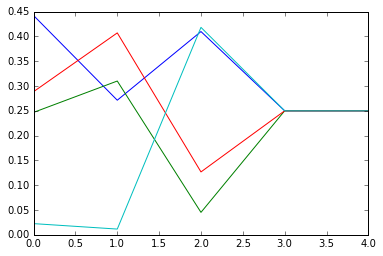

In [18]:
t = np.arange(5)
# plt.stem(t, xval[0].transpose(2,1,0)[0].T)
plt.plot(t, softmax(xval.squeeze().transpose(2,0,1)[4]),)

In [11]:
x = xval.squeeze().transpose(2,0,1)[7]
-(x*(2**x)).sum(0)#.mean()

array([ 1.20605803,  1.59281969,  2.22193074,  2.24920177], dtype=float32)

In [12]:
inflist = []
for nn, x in enumerate(xval.squeeze().transpose(2,0,1)):
    inflist.append((nn, -(x*(2**x)).sum(0).mean() ))
inflist = pd.DataFrame(inflist, columns=["ind", "info"])["info"]

In [13]:
inflist.sort_values(ascending=False)[:5]

94     2.438534
117    2.432468
90     2.365207
17     2.302182
11     2.280813
Name: info, dtype: float64

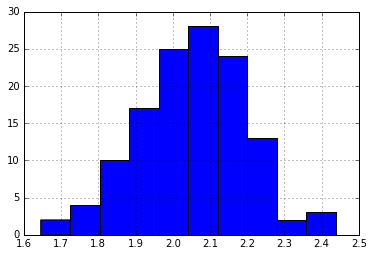

In [14]:
inflist.hist()

In [15]:
print("predicting")
test_batchloader = get_loader(conn, where="chr = 'chr22'", binary=False)
testbl = test_batchloader(500)
yhat_list = []
y_list = []
for nn, (xx, yy) in enumerate(testbl):
    "initialize the object"
    tfl = footprint_poisson(
            sparsity = 1e-2,
            batch_norm = False,
            BATCH_SIZE = 2**8,
            dropout = 0.25,
            xlen = 2001,
            display_step = 100,
            xdepth = 4,
            weight_decay = 0.0583,
            conv1_channels = 128,
            conv2_channels = 32,
            conv3_channels = 8,
            lr = 0.01,
            checkpoint_dir = flags.FLAGS.checkpoints,
            logdir = flags.FLAGS.logdir,
            )

    print(nn)
    yhat = tfl.predict(xx)
    yhat_list.append(yhat)
    y_list.append(yy)
    break

predicting


OperationalError: no such table: batf_seq_dna_atac

In [ ]:
all_yhat = np.stack(yhat_list)
tt = np.arange(len(yhat[0])) - 1000
valid = abs(tt) < 100
plt.plot(tt[valid], (all_yhat.mean(0).mean(0)[valid]))


In [ ]:
all_yhat = np.stack(yhat_list)
tt = np.arange(len(yhat[0])) - 1000
valid = abs(tt) < 50
yhat_mean = all_yhat.mean(0).mean(0)
print("yhat_mean", yhat_mean.shape)
yhat_var = all_yhat.reshape(-1, all_yhat.shape[-1]).var(0)
y_mean = np.mean(np.mean( np.stack(y_list), axis=0 ), axis=0)
print("y_mean", y_mean.shape)
print(yhat_var.shape)
fig, axs = plt.subplots(2)
axs[0].plot(tt[valid], np.exp(yhat_mean[valid]), c="b", zorder=1, lw=2 )
axs[0].plot(tt[valid], (yhat_var[valid]), c="g", zorder=2 )
axs[0].set_ylim(np.exp(np.r_[ min(yhat_mean[valid]), max(yhat_mean[valid]) ]))
print(min(yhat_var[valid]), max(yhat_var[valid]))
#axs[0].set_xlim([0, np.exp(max(yhat[0]))+0.01 ])
#for t_ in tt[ (y_mean>0) & valid]:
#    axs[0].axvline(t_, c='r')
#ax.scatter(tt, yy[0],c=(1,0,0,1), edgecolors="none", zorder=2 )
axs[1].plot(tt[valid], y_mean[valid], c='r')
#axs[1].stem(tt[valid], y_mean[valid], markerfmt='ro',linefmt='r-',
#            edgecolors="none", zorder=2 )
#axs[1].set_xlim([0, max(yy[0]+1)])